# Development resampling method step 3 processing

In [ ]:
%reset

# Preprocessing

## import

In [25]:
import copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import math
import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby
import matplotlib

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count
from os.path import exists

import matplotlib.pyplot as plt  # mother of plots focr Python

# import mlxtend
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import pyxdf  # read XDF files (LSL streams recordings)

import scipy.stats
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress
#from matplotlib.pyplot import cm
from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars
from scipy.stats import ks_2samp
from multiprocessing import Pool, cpu_count

import scipy.signal

## optimization

In [26]:
# warnings.simplefilter(action="ignore", category=FutureWarning)

# raw and processed data paths
# PATH_RAW = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/27.07.23/data"
# PATH_PROC = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/Events"
# PATH_FOREYE = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/ET_Output_MAD-sacc"
# PATH_TRG = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/TriggerFiles_fEEG"


# specify decimals format on pandas tables
# pd.options.display.float_format = "{:.5f}".format

# inline static plotting (default)
%matplotlib inline
# interactive plotting
# %matplotlib widget

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""


CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")


def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)

Total CPU threads: 8


## data paths & participant list

In [27]:

data_savepath_cleaned = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step1_2_cleaning_gazeProcessing/1_cleaned"
data_savepath_interpolated = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step1_2_cleaning_gazeProcessing/2_interpolated"

data_savepath_intermediateP = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step3_gazeProcessing/intermediateProcessing"
data_savepath_intervals = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step3_gazeProcessing/intervals"
data_savepath_processed_gazes = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step3_gazeProcessing"



# Getting the Folder without hidden files in ascending order 
# DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
# PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

# savepath = r'F:\WestbrookProject\SpaRe_Data\pre-processing_2023\step1_preparation\'
# os.chdir(r'F:\WestbrookProject\SpaRe_Data\pre-processed_csv\')

In [28]:
# Participant list of all participants that participated 5 sessions x 30 min
# in Westbrook city
# PartList = [1004, 1005, 1008, 1010, 1011, 1013, 1017, 1018, 1019, 1021, 1022, 1023, 1054, 1055, 1056, 1057, 1058, 1068, 1069, 1072, 1073, 1074, 1075, 1077, 1079, 1080]
# print(len(PartList),'participants') 

In [29]:
# # custom participant list, if only a subset of participants should be processed
PartList = [1004]

# Gaze Processing


In [30]:
# This will be used to select which version to use
# 1 == MAD_woBig # this is the version we should use (data-driven)
# 2 == 10_sec
define_intervals = 1

# Smoothing the Data: 5-point median Filter

In [31]:
# smooth coordinates with 5-point median filter
# based on remodnav --> has almost the same length as our filter
def smooth_coordinates(file, data):
    
    # the coordinates to be smoothed
    Xcorr_position_old = data["eyePositionCombinedWorld_x"].tolist()
    Ycorr_position_old = data["eyePositionCombinedWorld_y"].tolist()
    Zcorr_position_old = data["eyePositionCombinedWorld_z"].tolist()
    hpooX_old = data["processedCollider_hitPointOnObject_x"].tolist()
    hpooY_old = data["processedCollider_hitPointOnObject_y"].tolist()
    hpooZ_old = data["processedCollider_hitPointOnObject_z"].tolist()

    Xcorr_position = []
    Ycorr_position = []
    Zcorr_position = []
    hpooX = []
    hpooY = []
    hpooZ = []
    # for NH collider column as well
    hpooX_NH_old = data["processedCollider_NH_hitPointOnObject_x"].tolist()
    hpooY_NH_old = data["processedCollider_NH_hitPointOnObject_y"].tolist()
    hpooZ_NH_old = data["processedCollider_NH_hitPointOnObject_z"].tolist()

    hpooX_NH = []
    hpooY_NH = []
    hpooZ_NH = []
    
    # adapt algorithm to varying sampling rate --> first identify necessary sample window to cover a duration of 0.05 sec min
    # .... then apply nanmedian --> handle the edge cases approrpiately (start and end of file). 

    # smooth it:
    for s in range(len(Xcorr_position_old)):
        if s - 2 >= 0 and s + 2 <= len(Xcorr_position_old):
            Xcorr_position.append(
                np.nanmedian([Xcorr_position_old[s - 2 : s + 3]])
            )
            Ycorr_position.append(
                np.nanmedian([Ycorr_position_old[s - 2 : s + 3]])
            )
            Zcorr_position.append(
                np.nanmedian([Zcorr_position_old[s - 2 : s + 3]])
            )

            hpooX.append(np.nanmedian([hpooX_old[s - 2 : s + 3]]))
            hpooY.append(np.nanmedian([hpooY_old[s - 2 : s + 3]]))
            hpooZ.append(np.nanmedian([hpooZ_old[s - 2 : s + 3]]))

            # for NH as well
            hpooX_NH.append(np.nanmedian([hpooX_NH_old[s - 2 : s + 3]]))
            hpooY_NH.append(np.nanmedian([hpooY_NH_old[s - 2 : s + 3]]))
            hpooZ_NH.append(np.nanmedian([hpooZ_NH_old[s - 2 : s + 3]]))

        elif s - 2 < 0:
            Xcorr_position.append(np.nanmedian([Xcorr_position_old[: s + 3]]))
            Ycorr_position.append(np.nanmedian([Ycorr_position_old[: s + 3]]))
            Zcorr_position.append(np.nanmedian([Zcorr_position_old[: s + 3]]))

            hpooX.append(np.nanmedian([hpooX_old[: s + 3]]))
            hpooY.append(np.nanmedian([hpooY_old[: s + 3]]))
            hpooZ.append(np.nanmedian([hpooZ_old[: s + 3]]))

            # NH
            hpooX_NH.append(np.nanmedian([hpooX_NH_old[: s + 3]]))
            hpooY_NH.append(np.nanmedian([hpooY_NH_old[: s + 3]]))
            hpooZ_NH.append(np.nanmedian([hpooZ_NH_old[: s + 3]]))
        else:
            Xcorr_position.append(np.nanmedian([Xcorr_position_old[s - 2 :]]))
            Ycorr_position.append(np.nanmedian([Ycorr_position_old[s - 2 :]]))
            Zcorr_position.append(np.nanmedian([Zcorr_position_old[s - 2 :]]))

            hpooX.append(np.nanmedian([hpooX_old[s - 2 :]]))
            hpooY.append(np.nanmedian([hpooY_old[s - 2 :]]))
            hpooZ.append(np.nanmedian([hpooZ_old[s - 2 :]]))

            # NH
            hpooX_NH.append(np.nanmedian([hpooX_NH_old[s - 2 :]]))
            hpooY_NH.append(np.nanmedian([hpooY_NH_old[s - 2 :]]))
            hpooZ_NH.append(np.nanmedian([hpooZ_NH_old[s - 2 :]]))

#     for_eye_n = pd.read_csv(f"{PATH_FOREYE}/correTS_{uid}.csv", index_col=0) # unclear why this line exists (Jasmin)
    data["eyePositionCombinedWorld_x"] = Xcorr_position
    data["eyePositionCombinedWorld_y"] = Ycorr_position
    data["eyePositionCombinedWorld_z"] = Zcorr_position

    data["processedCollider_hitPointOnObject_x"]= hpooX
    data["processedCollider_hitPointOnObject_y"] = hpooY
    data["processedCollider_hitPointOnObject_z"] = hpooZ

    data["processedCollider_NH_hitPointOnObject_x"] = hpooX_NH
    data["processedCollider_NH_hitPointOnObject_y"] = hpooY_NH
    data["processedCollider_NH_hitPointOnObject_z"] = hpooZ_NH

   
    # save data --> to facilitate runtime, save data only in last processing funtion
#     newName = file.replace("data_interpolated.csv","data_smoothed.csv")
#     data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
    
    return data


## test code

In [32]:
# # test code
file= "1004_Session_1_ET_1_data_interpolated.csv"
data = pd.read_csv(os.path.join(data_savepath_interpolated, file))
data.head()


,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,timeStampDataPointStart_converted,cleanData,isBlink
0,1.618996e+09,1.618996e+09,1.618996e+09,1.0,1.0,3.698715,4.148895,31,31,3,-59.140545,2.383250,34.781898,-0.347088,-0.231328,0.908838,-0.071732,-0.018448,0.997238,-59.101711,2.384678,34.781570,-0.338667,-0.231240,0.912037,-0.062744,-0.018478,0.997849,-59.163315,2.382413,34.782089,-0.352012,-0.231392,0.906939,-0.076996,-0.018448,0.996857,-59.133713,2.385427,34.810440,-0.280929,-0.211922,0.936038,0.955704,0.027456,0.293047,12.235023,343.294128,1.609863,-0.087803,0.976901,0.194822,-59.099991,0.858675,34.790001,-59.178268,1.870465,35.084145,345.605347,335.328613,342.422760,-0.404309,0.248600,0.880189,0.834952,-0.292510,0.466147,0.373348,0.923383,-0.089304,-59.099991,0.858675,34.790001,-59.110550,1.955546,34.745995,344.902771,359.210938,354.450653,pavement_O.002,1.0,-61.306915,0.939402,40.454468,-165.163147,1.451688,-15.55587,terrain_O.001,2.0,-61.602016,0.742721,41.227188,-165.372559,-0.466505,-15.987518,0,0,0,pavement_O.002,-61.306915,0.939402,40.454468,-165.163147,1.451688,-15.55587,notReplaced,1,pavement

In [33]:
pd.set_option('display.max_columns', None)

# # Assuming 'data' is your DataFrame
# data_head = data.head(50)

# Display head horizontally
with pd.option_context('display.max_rows', None, 'display.width', 1000):
#     display(data_head)
    display(data.iloc[200:270])

,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,timeStampDataPointStart_converted,cleanData,isBlink
200,1.618996e+09,1.618996e+09,1.618996e+09,1.000000,1.000000,3.527573,3.583771,31,31,3,-59.100067,2.391956,34.782993,0.368854,-0.000367,0.929475,0.206360,0.122757,0.970734,-59.068977,2.393296,34.782433,0.360149,-0.002383,0.932884,0.197189,0.121063,0.972855,-59.130333,2.390652,34.783539,0.377300,0.001589,0.926087,0.215271,0.124390,0.968597,-59.099655,2.392750,34.811836,0.168634,-0.127344,0.977418,0.985573,0.007252,-0.169096,7.316162,9.788857,0.418921,0.014445,0.991832,0.126730,-59.099991,0.858675,34.790001,-59.143173,1.842346,35.098740,350.191223,350.230347,0.840331,-0.167207,0.170360,0.971092,0.985816,0.014452,0.167207,0.014452,0.985276,-0.170360,-59.099991,0.858675,34.790001,-59.107864,1.955128,34.747467,344.640076,1.897310,354.978943,Building_162,1.0,-42.695911,2.375648,76.119781,-45.982460,10.830215,82.104797,Fence_34,2.0,-38.485092,2.371434,86.730621,-53.881447,1.939403,89.793091,345,0,0,Building_162,-42.695911,2.375648,76.119781,-45.982460,10.830215,82.104797,notReplaced,0,Building_162,-42.695911,2

In [34]:
# test code for linear interpolation

dataTest = data.iloc[:20].copy()

dataTest['SamplingRate'] = 1/dataTest['timeStampDataPointStart_converted'].diff()

print(dataTest['SamplingRate'].mean())
print(dataTest['SamplingRate'].median())
# dataTest.set_index('timestamp_seconds', inplace=True)
# # Resample the data frame to a consistent sampling rate (e.g., every second)
# resampled_df = dataTest.resample('1S').mean()

69.9233621561949
87.64243475353636


In [35]:
with pd.option_context('display.max_rows', None, 'display.width', 1000):
#     display(data_head)
    display(dataTest.head(20))

,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,timeStampDataPointStart_converted,cleanData,isBlink,SamplingRate
0,1.618996e+09,1.618996e+09,1.618996e+09,1.0,1.0,3.698715,4.148895,31,31,3,-59.140545,2.383250,34.781898,-0.347088,-0.231328,0.908838,-0.071732,-0.018448,0.997238,-59.101711,2.384678,34.781570,-0.338667,-0.231240,0.912037,-0.062744,-0.018478,0.997849,-59.163315,2.382413,34.782089,-0.352012,-0.231392,0.906939,-0.076996,-0.018448,0.996857,-59.133713,2.385427,34.810440,-0.280929,-0.211922,0.936038,0.955704,0.027456,0.293047,12.235023,343.294128,1.609863,-0.087803,0.976901,0.194822,-59.099991,0.858675,34.790001,-59.178268,1.870465,35.084145,345.605347,335.328613,342.422760,-0.404309,0.248600,0.880189,0.834952,-0.292510,0.466147,0.373348,0.923383,-0.089304,-59.099991,0.858675,34.790001,-59.110550,1.955546,34.745995,344.902771,359.210938,354.450653,pavement_O.002,1.0,-61.306915,0.939402,40.454468,-165.163147,1.451688,-15.55587,terrain_O.001,2.0,-61.602016,0.742721,41.227188,-165.372559,-0.466505,-15.987518,0,0,0,pavement_O.002,-61.306915,0.939402,40.454468,-165.163147,1.451688,-15.55587,notReplac

In [36]:
data['SamplingRate'] = 1/data['timeStampDataPointStart_converted'].diff()

data2 = smooth_coordinates(file, data)

D:\Software\Programme\Anaconda3\envs\graphs\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


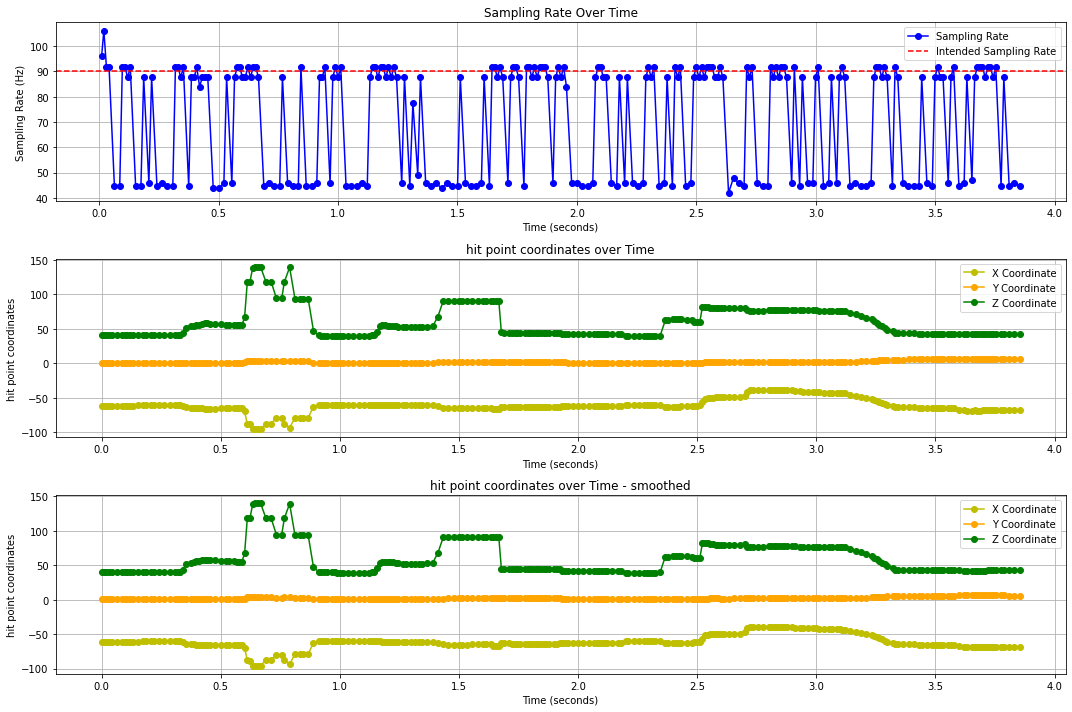

In [37]:

window = slice(0, 250)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))

# Plotting on the first subplot (axes[0])
axes[0].plot(data['timeStampDataPointStart_converted'].iloc[window], data['SamplingRate'].iloc[window], marker='o', linestyle='-', color='b', label='Sampling Rate')
axes[0].axhline(y=90, color='r', linestyle='--', label='Intended Sampling Rate')  # Changed linestyle to '--'

axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Sampling Rate (Hz)')
axes[0].set_title('Sampling Rate Over Time')
axes[0].legend()  # Fixed typo from "egend()" to "legend()"
axes[0].grid(True)


axes[1].plot(data['timeStampDataPointStart_converted'].iloc[window], data['processedCollider_NH_hitPointOnObject_x'].iloc[window], marker='o', linestyle='-', color='y', label='X Coordinate')
axes[1].plot(data['timeStampDataPointStart_converted'].iloc[window], data['processedCollider_NH_hitPointOnObject_y'].iloc[window], marker='o', linestyle='-', color='orange', label='Y Coordinate')
axes[1].plot(data['timeStampDataPointStart_converted'].iloc[window], data['processedCollider_NH_hitPointOnObject_z'].iloc[window], marker='o', linestyle='-', color='g', label='Z Coordinate')

axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('hit point coordinates')
axes[1].set_title('hit point coordinates over Time')
axes[1].legend()  # Fixed typo from "egend()" to "legend()"
axes[1].grid(True)

axes[2].plot(data2['timeStampDataPointStart_converted'].iloc[window], data2['processedCollider_NH_hitPointOnObject_x'].iloc[window], marker='o', linestyle='-', color='y', label='X Coordinate')
axes[2].plot(data2['timeStampDataPointStart_converted'].iloc[window], data2['processedCollider_NH_hitPointOnObject_y'].iloc[window], marker='o', linestyle='-', color='orange', label='Y Coordinate')
axes[2].plot(data2['timeStampDataPointStart_converted'].iloc[window], data2['processedCollider_NH_hitPointOnObject_z'].iloc[window], marker='o', linestyle='-', color='g', label='Z Coordinate')

axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('hit point coordinates')
axes[2].set_title('hit point coordinates over Time - smoothed')
axes[2].legend()  # Fixed typo from "egend()" to "legend()"
axes[2].grid(True)



plt.tight_layout()  # Ensures plots are properly spaced
plt.show()

In [38]:
print(data2['SamplingRate'].mean())
print(data2['SamplingRate'].median())

dataTest = data.iloc[:20].copy()



71.29039311494701
87.64243475309995


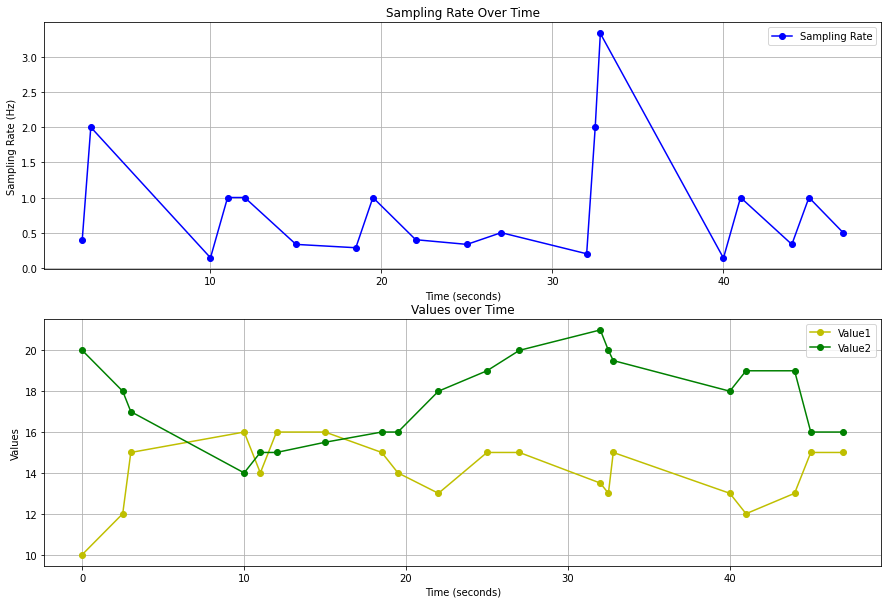

In [107]:
# Example data frame
dataSim = {
    'timestampSeconds': [0, 2.5, 3, 10, 11, 12, 15, 18.5, 19.5, 22, 25, 27, 32, 32.5, 32.8, 40, 41, 44, 45, 47],
    'value1': [10, 12, 15, 16, 14, 16, 16, 15, 14, 13, 15, 15, 13.5, 13, 15, 13, 12, 13, 15, 15],
    'value2': [20, 18, 17, 14, 15, 15, 15.5, 16, 16, 18, 19, 20, 21, 20, 19.5, 18, 19, 19, 16, 16]
}
dfSim = pd.DataFrame(dataSim)
dfSim['samplingRate'] = 1/dfSim['timestampSeconds'].diff()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Plotting on the first subplot (axes[0])
axes[0].plot(dfSim['timestampSeconds'], dfSim['samplingRate'], marker='o', linestyle='-', color='b', label='Sampling Rate')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Sampling Rate (Hz)')
axes[0].set_title('Sampling Rate Over Time')
axes[0].legend()  # Fixed typo from "egend()" to "legend()"
axes[0].grid(True)


axes[1].plot(dfSim['timestampSeconds'], dfSim['value1'], marker='o', linestyle='-', color='y', label='Value1')
axes[1].plot(dfSim['timestampSeconds'], dfSim['value2'], marker='o', linestyle='-', color='g', label='Value2')

axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Values')
axes[1].set_title('Values over Time')
axes[1].legend()  # Fixed typo from "egend()" to "legend()"
axes[1].grid(True)

In [131]:

dfSim['timestamp'] = pd.to_datetime(dfSim['timestampSeconds'], unit = 's')
oldIndex = dfSim.index

dfSim.set_index('timestamp', inplace = True)
dfSim.head()

# resamplingLinear = dfSim.resample('500L').interpolate(method='linear')


testi = dfSim.resample('700L').interpolate(method= 'time')

In [135]:
dfSim.head(20)

,timestampSeconds,value1,value2,samplingRate
timestamp,,,,
1970-01-01 00:00:00.000,0.0,10.0,20.0,NaN
1970-01-01 00:00:02.500,2.5,12.0,18.0,0.400000
1970-01-01 00:00:03.000,3.0,15.0,17.0,2.000000
1970-01-01 00:00:10.000,10.0,16.0,14.0,0.142857
1970-01-01 00:00:11.000,11.0,14.0,15.0,1.000000
1970-01-01 00:00:12.000,12.0,16.0,15.0,1.000000
1970-01-01 00:00:15.000,15.0,16.0,15.5,0.333333
1970-01-01 00:00:18.500,18.5,15.0,16.0,0.285714
1970-01-01 00:00:19.500,19.5,14.0,16.0,1.000000


In [136]:
testi.head(20)

,timestampSeconds,value1,value2,samplingRate
timestamp,,,,
1970-01-01 00:00:00.000,0.0,10.0,20.0,NaN
1970-01-01 00:00:00.700,0.0,10.0,20.0,NaN
1970-01-01 00:00:01.400,0.0,10.0,20.0,NaN
1970-01-01 00:00:02.100,0.0,10.0,20.0,NaN
1970-01-01 00:00:02.800,0.0,10.0,20.0,NaN
1970-01-01 00:00:03.500,0.0,10.0,20.0,NaN
1970-01-01 00:00:04.200,0.0,10.0,20.0,NaN
1970-01-01 00:00:04.900,0.0,10.0,20.0,NaN
1970-01-01 00:00:05.600,0.0,10.0,20.0,NaN


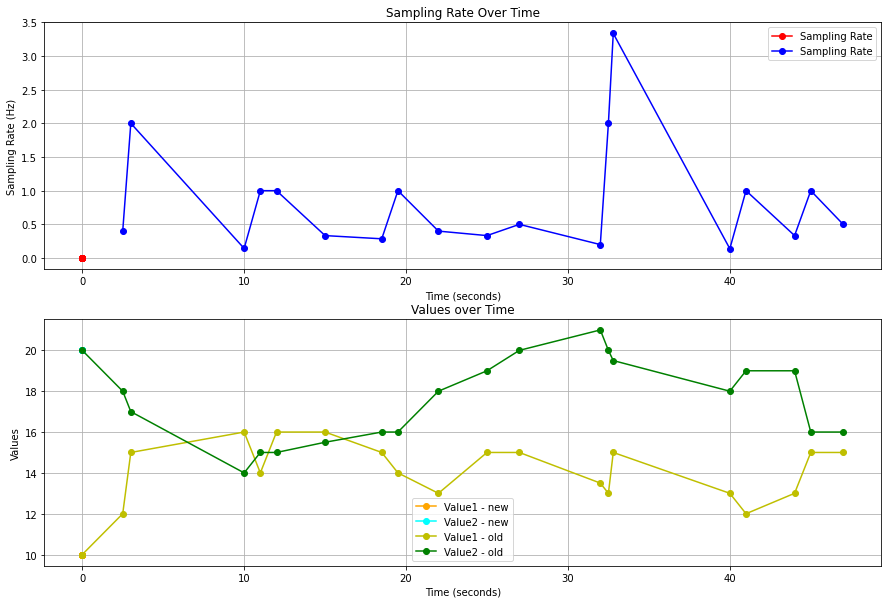

In [132]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Plotting on the first subplot (axes[0])
axes[0].plot(testi['timestampSeconds'], testi['timestampSeconds'].diff(), marker='o', linestyle='-', color='r', label='Sampling Rate')
axes[0].plot(dfSim['timestampSeconds'], dfSim['samplingRate'], marker='o', linestyle='-', color='b', label='Sampling Rate')

axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Sampling Rate (Hz)')
axes[0].set_title('Sampling Rate Over Time')
axes[0].legend()  # Fixed typo from "egend()" to "legend()"
axes[0].grid(True)


axes[1].plot(testi['timestampSeconds'], testi['value1'], marker='o', linestyle='-', color='orange', label='Value1 - new')
axes[1].plot(testi['timestampSeconds'], testi['value2'], marker='o', linestyle='-', color='cyan', label='Value2 - new')

axes[1].plot(dfSim['timestampSeconds'], dfSim['value1'], marker='o', linestyle='-', color='y', label='Value1 - old')
axes[1].plot(dfSim['timestampSeconds'], dfSim['value2'], marker='o', linestyle='-', color='g', label='Value2 - old')

axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Values')
axes[1].set_title('Values over Time')
axes[1].legend()  # Fixed typo from "egend()" to "legend()"
axes[1].grid(True)

In [78]:
import pandas as pd

# Sample data
dataSim = {
    'timestampSeconds': [
        '2023-10-01 00:00:01.000',
        '2023-10-01 00:00:01.500',
        '2023-10-01 00:00:04.500',
        '2023-10-01 00:00:05.000'
    ],
    'value': [10, 15, 45, 50]
}

dfSim2 = pd.DataFrame(data)
dfSim2['timestampSeconds'] = pd.to_datetime(dfSim2['timestampSeconds'])
dfSim2.set_index('timestampSeconds', inplace=True)

print("Original DataFrame:\n", dfSim)


Original DataFrame:
                          value
timestampSeconds              
2023-10-01 00:00:01.000     10
2023-10-01 00:00:01.500     15
2023-10-01 00:00:04.500     45
2023-10-01 00:00:05.000     50


In [79]:
direct_interpolation = dfSim2.resample('500L').interpolate(method='linear')
print("Direct Interpolation:\n", direct_interpolation)

Direct Interpolation:
                          value
timestampSeconds              
2023-10-01 00:00:01.000   10.0
2023-10-01 00:00:01.500   15.0
2023-10-01 00:00:02.000   20.0
2023-10-01 00:00:02.500   25.0
2023-10-01 00:00:03.000   30.0
2023-10-01 00:00:03.500   35.0
2023-10-01 00:00:04.000   40.0
2023-10-01 00:00:04.500   45.0
2023-10-01 00:00:05.000   50.0


In [80]:
resampled_df = dfSim2.resample('1S').asfreq()
interpolated_df = resampled_df.interpolate(method='time')

print("Resampled DataFrame:\n", resampled_df)
print("Interpolated DataFrame:\n", interpolated_df)

Resampled DataFrame:
                      value
timestampSeconds          
2023-10-01 00:00:01   10.0
2023-10-01 00:00:02    NaN
2023-10-01 00:00:03    NaN
2023-10-01 00:00:04    NaN
2023-10-01 00:00:05   50.0
Interpolated DataFrame:
                      value
timestampSeconds          
2023-10-01 00:00:01   10.0
2023-10-01 00:00:02   20.0
2023-10-01 00:00:03   30.0
2023-10-01 00:00:04   40.0
2023-10-01 00:00:05   50.0


In [3]:
interpolated = np.zeros(10, dtype=bool)
print(interpolated)

[False False False False False False False False False False]
